In [13]:
import numpy as np
import pandas as pd
import pickle

from classes.ou_network import OU_Network

from classes.internal_states.lc_omniscient_DIS import Local_computations_omniscient_DIS
from classes.internal_states.lc_omniscient_CIS import Local_computations_omniscient_CIS
from classes.internal_states.normative_DIS import Normative_DIS

from classes.action_states.discounted_gain_soft_horizon_TSAS import Discounted_gain_soft_horizon_TSAS
from classes.action_states.undiscounted_gain_hard_horizon_TSAS import Undiscounted_gain_hard_horizon_TSAS
from classes.action_states.experience_discrete_3D_AS import Experience_discrete_3D_AS
from classes.action_states.experience_conti_3D_AS import Experience_conti_3D_AS

from classes.sensory_states.omniscient_ST import Omniscient_ST

from classes.agent import Agent
from classes.experiment import Experiment

from methods.policies import softmax_policy_init, three_d_softmax_policy_init, discrete_policy_init
from methods.empirical_priors import generate_discrete_empirical_priors, generate_gaussian_empirical_priors
from methods.action_values_priors import action_values_from_mtv_norm


In [14]:
## Import behavioural experiment
with open('/home/vbtesh/documents/CompProjects/vbtCogSci/csl2analysis/data/csl_2_modelling_data.obj', 'rb') as inFile:
    modelling_data = pickle.load(inFile)

print(modelling_data.keys())


dict_keys(['59402f40e9b44100013b1789', '59de425bbe399f0001e4975e', '5b6baad47e435d0001c1c88f', '5b74413e722bd2000195c067', '5ba4d6c929629d00014e6c28', '5badf0aeae1d020001df2cc7', '5c6d938c79151c00017c7560', '5c74f0d525c76b0010706736', '5c9124ef3b7f9e0013728485', '5cae09506d573900175d4727', '5cb304b63742a400153b756d', '5ccc758ab11510001584a1af', '5cd98287b0c5ec0001e0965a', '5cdeaeb3557fbd00018a2c59', '5cf92c7255e1370001e54adb', '5d29fbc8f91bdd0016e98503', '5d36ff998129260015c6de19', '5d6e3252dfe6d10001dbe508', '5d94c6f5dc0b0e001465072e', '5da60411423c170017b7dc0f', '5dc56fbac34fc53e4e78b820', '5e29e902c2253a0587298e26', '5e5eb4843accc91e2443212f', '5e87a0b5fc57a7415442f97e', '5e9948b69223aa17c21564f4', '5e99e838545b26058749d068', '5ecba4b6ef75d53505406d57', '5ecd7b06a1a9170e7806f51e', '5ed8be74a4175a01156004b0', '5edaa4924ea9bd6f14f3d618', '5edbaae1b9f9f68349ce80f3', '5ef109c89196fa6d5cf6c005', '5ef8a0b375e30603ebc12510', '5f1b69a1459c1e0009a83009', '5f2dbc04160a0f0d88ee4440', '5f31671e

In [15]:
part_key = '60bd04a3749e1ca47e54d3e1'
conditions = ['generic', 'congruent', 'incongruent', 'implausible']
cond = conditions[0]


In [16]:
# Model fitting
fitting = False # If false, no data will be used 

## Data from trial
part_data = modelling_data[part_key]['trials'][cond]
print(modelling_data[part_key].keys())
posterior = part_data['posterior']
print(posterior)
data = part_data['data']
inters = part_data['inters']
inters_fit = part_data['inters_fit']
judgement_data = part_data['links_hist']

dict_keys(['trial_order', 'trials'])
[1.  0.5 0.  0.5 0.  0. ]


In [17]:

# General model parameters (true for all trials)
if fitting:
    N = data.shape[0] - 1
    K = data.shape[1]
else:
    N = 300
    K = 3
links = np.array([-1, -0.5, 0, 0.5, 1])
theta = 0.5
dt = 0.2
sigma = 3

# Smoothing parameter for discrete posterior distributions
smoothing = 1e-20

# Set up priors
flat_prior = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
flat_prior = np.tile(flat_prior, (6, 1))
random_prior = np.random.rand(6, 5)
random_prior = random_prior / random_prior.sum(axis=1).reshape((6, 1))
prior_perfect = np.array([[1, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0],
                             [0, 0, 1, 0, 0],
                             [1, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0],
                             [0, 0, 1, 0, 0]])
# Emprical Priors
if 'prior' in part_data.keys():
    part_map = part_data['prior'] # Participant's maximum a priori
    temp = 5 # Must be explored further
    sd = 1e5
    discrete_empirical_prior, discrete_prior_entropy = generate_discrete_empirical_priors(part_map, links, temp)
    continuous_empirical_prior, continuous_prior_entropy = generate_gaussian_empirical_priors(part_map, sd)
else:
    discrete_empirical_prior = random_prior
    sd = 1e5
    continuous_empirical_prior = np.array([[0, 0, 0, 0, 0, 0],
                                               [sd, sd, sd, sd, sd, sd]]).T


## Final prior assignment
prior = discrete_empirical_prior

# Ground truth model
## Import from behavioural experiment
gt_behavioural_exp = part_data['ground_truth']
## Any model as np.ndarray
custom_model = np.array([-1, 0, 0, -1, 0, 0])
## Final ground truth assignment
true_model = custom_model
#true_model = gt_behavioural_exp

# Action parameters
## Number of model to sample from the posterior
C = 1
## Different action possibility
poss_actions = np.arange(-100, 100)
poss_actions = np.array([85, 45, 0, -45, -85])
poss_actions = np.arange(-100, 101, step=10)
poss_actions_abs = np.arange(0, 101, step=10)

## Define action length (TO BE REFINED FOR FITTING DATA)
action_len = 5 

## Policy for action selection from action values
policy_funcs = softmax_policy_init(1) # Returns three function: sample, pmf, params
policy_funcs_3d = three_d_softmax_policy_init(1)
policy_funcs_discrete = discrete_policy_init()

## Parameters
epsilon = 1e-2 # Certainty threshold: agent stops intervening after entropy goes below epsilon
knowledge = False  # Can be a model as nd.array, True for perfect knowledge, 'random' for random sampling and False for posterior based sampling

## Special parameters for tree searches
horizon = 1e-1 # For soft horizon discounted gain
discount = 0.1 # For soft horizon discounted gain
depth = 1 # Horizon for hard horizon undiscounted gain

## Special parameters for experience actions states
max_acting_time = 10
max_obs_time = 10
experience_measure = 'change' # Can be "information" or "change"
mus = np.array([70, 4, 4])
cov = np.array([[20**2, 0, 0],
                [0, 1, 0],
                [0, 0, 1]])
prior_params = (mus, cov)
# Special parameters for computing the learning rate in discrete gaussian action
learning_param = 1

dist, dist_3d, prior_action_values, sample_space = action_values_from_mtv_norm(poss_actions_abs, 
                                                                                   max_acting_time, 
                                                                                   max_obs_time,
                                                                                   mus, cov)

# alpha, learning rate for change in sensory state
alpha = 1/3
change = 'raw' # Can be 'normalised', 'relative', 'raw'

## General behaviour parameter
behaviour = 'actor'   # Can be 'obs', 'random' or 'actor'



In [18]:
sensory_state = Omniscient_ST(N, K, alpha, change)
    
action_state = Discounted_gain_soft_horizon_TSAS(N, K, behaviour, epsilon, poss_actions, action_len, policy_funcs,  C, knowledge, discount, horizon)
action_state = Undiscounted_gain_hard_horizon_TSAS(N, K, behaviour, epsilon, poss_actions, action_len, policy_funcs, C, knowledge, depth)
#action_state = Experience_discrete_3D_AS(N, K, behaviour,  -np.inf**epsilon, poss_actions_abs, policy_funcs_3d, dt, max_acting_time, max_obs_time, experience_measure, prior_action_values)
action_state = Experience_conti_3D_AS(N, K, behaviour, -np.inf*epsilon, poss_actions_abs, policy_funcs_discrete, dt, max_acting_time, max_obs_time, experience_measure, prior_params, learning_param)

internal_state = Normative_DIS(N, K, prior, links, dt, theta, sigma, sample_params=False, smoothing=smoothing)
internal_state = Local_computations_omniscient_DIS(N, K, prior, links, dt, theta, sigma, sample_params=False, smoothing=smoothing)
internal_state = Local_computations_omniscient_CIS(N, K, continuous_empirical_prior, links, dt, theta, sigma, sample_params=False, smoothing=smoothing)

external_state = OU_Network(N, K, true_model, theta, dt, sigma)

agent = Agent(N, sensory_state, internal_state, action_state)

if fitting:
    external_state.load_trial_data(data)
    action_state.load_action_data(inters, inters_fit, data)
    internal_state.load_judgement_data(judgement_data, posterior)
    
experiment = Experiment(agent, external_state)


In [19]:
# Run experiment
if fitting:
    experiment.fit()
else:
    experiment.run()

#experiment.entropy_report()

True model: [-1.  0.  0. -1.  0.  0.]

 Realisation 1 out of 1: 

Iter: 0
Current MAP: [0. 0. 0. 0. 0. 0.] Entropy: 77.59118398904941
Iter: 10
Current MAP: [ 0.   -1.39  0.   -0.08 -0.02  0.  ] Entropy: 10.074335975670806
Iter: 20
Current MAP: [-16.41   2.51  -0.    -0.17  -0.    -1.13] Entropy: -21.903567638109433
Iter: 30
Current MAP: [-4.75  4.99 -0.   -0.29  0.01 -0.58] Entropy: -26.209863893725018
Iter: 40
Current MAP: [-0.1  -0.27 -0.01 -0.35  0.01 -0.38] Entropy: -30.9265693275431
Iter: 50
Current MAP: [-0.09 -0.09 -0.01 -0.37 -0.03 -0.31] Entropy: -32.1624409209126
Iter: 60
Current MAP: [-0.14 -0.08 -0.06 -0.34 -0.15 -0.26] Entropy: -32.56567017217161
Iter: 70
Current MAP: [-0.2  -0.05 -0.08 -0.33 -0.1  -0.32] Entropy: -32.86959529641115
Iter: 80
Current MAP: [-0.16 -0.04 -0.08 -0.35 -0.1  -0.29] Entropy: -33.36550523969704
Iter: 90
Current MAP: [-0.14 -0.09 -0.1  -0.35 -0.23 -0.24] Entropy: -33.73372352504707
Iter: 100
Current MAP: [-0.16 -0.09 -0.12 -0.33 -0.25 -0.23] Entropy

True model: [-1.  0.  0. -1.  0.  0.]
Final MAP: [-0.2  -0.04 -0.07 -0.28 -0.03 -0.14]


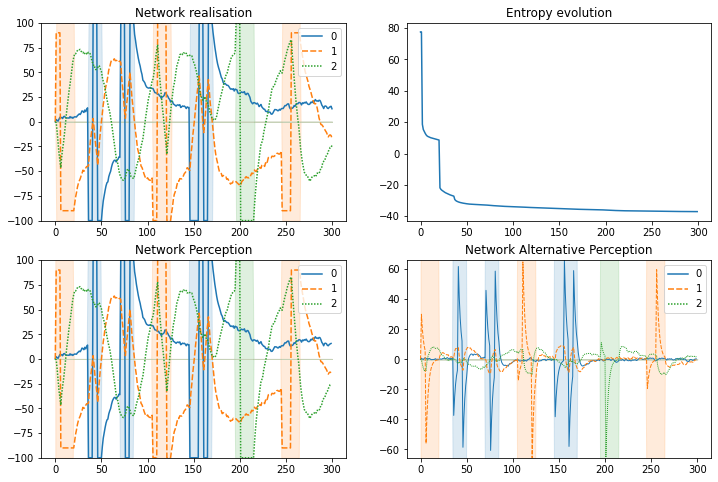

In [20]:
experiment.entropy_report()

In [21]:
print(action_state._prior_params[0])
print(action_state._current_params[0])

[70  4  4]
[100   4   6]


In [22]:
action_state._variable_history


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [23]:
print(action_state._last_planned_action)

(1, -90)


In [24]:
policy_funcs_3d[0](experiment.agent.action_state._current_action_values)

AttributeError: 'Experience_conti_3D_AS' object has no attribute '_current_action_values'

In [ ]:
experiment.agent.internal_state.posterior_entropy_over_links

array([1.34570002e-18, 1.87427417e-18, 1.87427417e-18, 1.34570002e-18,
       1.87427417e-18, 1.87427417e-18])

In [ ]:
LL = internal_state._posterior_params_history[150]
LL_n = LL - np.amax(LL)
lh = np.exp(LL_n) / np.exp(LL_n).sum()

print(lh)
print(LL_n)

internal_state._models_to_links(lh)

[0. 0. 0. ... 0. 0. 0.]
[-2834.05289309 -1794.34791427 -1459.69332394 ... -7035.99683975
 -7389.14122972 -8441.92183262]


array([[7.85854037e-001, 2.14105303e-001, 4.06597860e-005,
        2.33178580e-011, 5.16432285e-021],
       [1.90787562e-007, 1.05966371e-002, 9.75950524e-001,
        1.34523492e-002, 2.99371013e-007],
       [0.00000000e+000, 7.59715085e-158, 1.00000000e+000,
        2.80250220e-140, 0.00000000e+000],
       [1.00000000e+000, 4.88885135e-133, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 7.59715085e-158, 1.00000000e+000,
        5.34491750e-154, 0.00000000e+000],
       [0.00000000e+000, 3.64259929e-146, 1.00000000e+000,
        6.77041844e-159, 0.00000000e+000]])

# Fitting

When fitting, we have data about the external states, the interventions a participant made, i.e. action states, and their judgement or any other direct measure of their internal states. 

By definition, sensory states are never observed because they are always implicit. In many cases such as in a control environment, internal states will not be directly observed using judgement but should be inferred from actions states

The dependencies between all core modules imply that fitting a dataset of observations, actions and judgments is only valid for the current global parametrisation of the agent, i.e. the collection of internal, sensory and action states. We can compare how things change when changing one of the modules but we cannot seperate the likelihoods over the different modules.

## Where should the data be stored when fitting?

Basically the question is programming related and asks how should the data be split when initialising the states of the experiment. It could be a seperate method "load_data" called seperately from initialising the agent and the external states. Given the current way the states objects are structured, it creates an inconsistency where parameters have to be specified before hand before being overwritten.

# Questions

## Number of datapoints

The log likelihood is highly sensitive to the number of datapoints. If we assume that the participant cannot observe all datapoints for instance, we artificially reduce the log likelihood. So what can we do?

What do we do when encountering negative infinities, i.e. probability 0. Conceptually it can make sense but it is still highly dependent on the number of datapoints again as some discrete models will simply converge numerically to point masses given enough datapoints. Can we simply conclude to the extreme unlikeliness of this model?

## Number of parameters

Also the number of parameters in a model is not straightforward: in the discrete case model representation has 15625 and links representation has 30, but one is a direct function of the other without adding any additional parameters. In a continuous case, easier to represent as it is the collection of parameters of the PDF.